実行したいセルに単語を入力したあと、Ctrl + Enter で実行してください。
> わからないことがあったら気軽に質問してください。

# 日本語の Wikipedia の記事で学習した単語分散表現
このデモでは、人工知能によって「ベクトル」に変換された「単語」を使って、その「ベクトル」がどのように「単語」の特徴をとらえているかを見ていきます。

## ライブラリのインストール

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager 
import gensim
import seaborn as sns
import cv2
from os import path
from scipy import signal
from scipy import misc
sns.set()

In [11]:
font_path = '/usr/share/fonts/truetype/fonts-japanese-mincho.ttf'
fp = font_manager.FontProperties(fname=font_path)
plt.rcParams["font.family"] = fp.get_name()

#import matplotlib.font_manager
#matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')



IPAexMincho


## 単語ベクトルを見てみる

In [3]:
# 単語分散表現を読み込む

vec = gensim.models.KeyedVectors.load_word2vec_format('/home/okazaki/install/jawiki.bin', binary=True, unicode_errors='ignore')

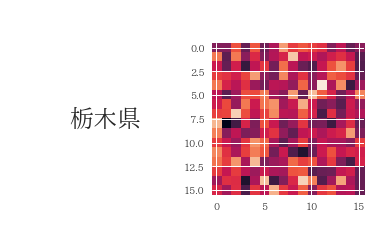

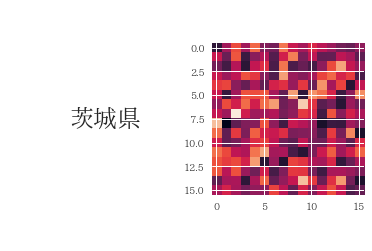

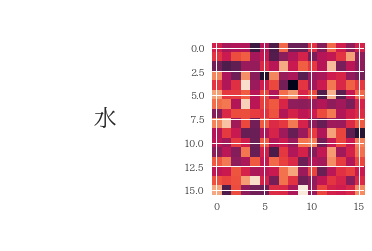

array([-0.26552305, -0.26967752,  0.27101582, -0.38676125,  0.28956363,
       -0.34571406, -0.08944321,  0.5598806 ,  0.1915539 ,  0.28988597,
        0.2093499 ,  0.14678925, -0.26350775, -0.03260737, -0.39187533,
       -0.24516748,  0.4200362 , -0.42514825,  0.42286307, -0.2391351 ,
        0.11768519, -0.27497014, -0.07275463,  0.09183327,  0.7495942 ,
       -0.01504772,  0.04234359, -0.08572177,  0.06288831,  0.14221872,
        0.00715072, -0.44587815,  0.03074083, -0.38795695,  0.06102454,
       -0.60135627, -0.01541477,  0.17472826, -0.3274164 ,  0.3798543 ,
       -0.03324236, -0.37610173, -0.4736631 ,  0.00677247,  0.274242  ,
        0.5183447 ,  0.20519096, -0.4735934 ,  0.20236918,  0.15901533,
        0.06514866,  0.22686465,  0.5596911 , -0.2185093 , -0.3232636 ,
        0.475059  , -0.10012705,  0.15919709, -0.23005244, -0.05910872,
        0.3271913 ,  0.25205508,  0.16818942, -0.39117637,  0.417262  ,
        0.08676066, -0.04379294,  0.14442772, -0.16918923, -0.32

In [12]:


vec['栃木県']

def print_vec(word):
    vector = vec[word]
    norm_image = cv2.normalize(vector, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
    vec_img = norm_image.astype(np.uint8)
    vec_img = np.reshape(vec_img, (16,16))
    
    fig, ax = plt.subplots(1,2)
    
    ax[0].text(0.5, 0.5, word, horizontalalignment='center', verticalalignment='center', fontsize=24)
    ax[0].axis('off')
    ax[1].imshow(vec_img)
    plt.show()
    
    
    
print_vec('栃木県')
print_vec('茨城県')
print_vec('水')
vec['栃木県']
    

In [5]:
len(vec['栃木県'])

256

In [6]:
# 単語ベクトルを描画する関数を作る

def plot_vector(x):
    plt.xlim(0, len(x))
    plt.plot(range(len(x)), x, 'b')

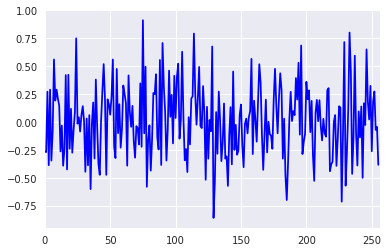

In [7]:
plot_vector(vec['栃木県'])

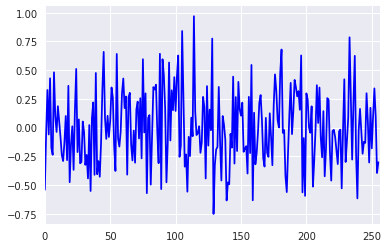

In [8]:
plot_vector(vec['茨城県'])

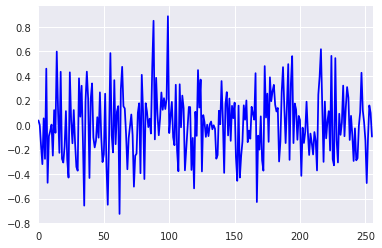

In [9]:
plot_vector(vec['コンピュータ'])

In [10]:
plot_vector(vec[''])

KeyError: "word '' not in vocabulary"

## ふたつの単語ベクトルがどれくらい似てるか計算する

\begin{equation}
\vec{a} = (a_1, a_2, \cdots, a_n) \\
\vec{b} = (b_1, b_2, \cdots, b_n)
\end{equation}
に対して

\begin{equation}
cos(\vec{a},\vec{b})
= \frac{\vec{a} \cdot \vec{b}}{|a||b|}
= \frac{a_1 b_1 + \cdots + a_n b_n}{\sqrt{a_{1}^2 + \cdots + a_{n}^2}\sqrt{b_{1}^2 + \cdots + b_{n}^2}}
\end{equation}

をコサイン類似度と言います。

In [ ]:
vec.similarity('栃木県', '茨城県')

In [ ]:
vec.similarity('栃木県', 'コンピュータ')

In [ ]:
vec.similarity('コンピュータ', '')

## 似てる単語を調べる

In [ ]:
vec.most_similar(positive=['栃木県'])

In [ ]:
vec.most_similar(positive=['コンピュータ'])

In [ ]:
vec.most_similar(positive=['嬉しい'])

In [ ]:
vec.most_similar(positive=['さんま'])

In [ ]:
vec.most_similar(positive=['サンマ'])

In [ ]:
vec.most_similar(positive=[''])

## 単語ベクトルを足し引きしてみる

In [ ]:
vec['栃木県']

In [ ]:
vec['宇都宮'] - vec['栃木県'] + vec['茨城県']

In [ ]:
vec.similar_by_vector(vec['宇都宮'] - vec['栃木県'] + vec['茨城県'])

In [ ]:
vec.similar_by_vector(vec['宇都宮'])

In [ ]:
vec.most_similar(positive=['東京', 'アメリカ'], negative=['日本'])

In [ ]:
vec.most_similar(positive=['のび太', 'ピカチュウ'], negative=['ドラえもん'])

In [ ]:
vec.most_similar(positive=['', ''], negative=[''])